In [1]:
import ee
import datetime
import os
import itertools
import sys
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE
import ast

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('..')

In [4]:
from BackGround_modules.Class_2_Classify_Fourier_Img   import Classification
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

##### Prepare basic parameters

In [5]:
# define the years to be classified
year_name  = ['2014_2016','2017_2019']

# import north_china_plain boundary
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

In [6]:
year_name

['2014_2016', '2017_2019']

##### Prepare input_image for classification

1) Climate date

In [7]:
# prepare the climate data
Climate_mean = [ee.Image(f"users/wangjinzhulala/North_China_Plain_Python/Climate_data/Mean_{year}")
               .clip(North_China_Plain)  for year in year_name]

2) Sentinel date

In [8]:
# Function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask  = 1 << 10;
    cirrusBitMask = 1 << 11;

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    # Return the masked and scaled data, without the QA bands.
    return image.updateMask(mask)\
                 .select("B.*")\
                 .copyProperties(image, ["system:time_start"])



# here composite Sentinel-2 multispectrum image of year [2015-2017] for classification of [2014-2016]
#            and Sentinel-2 multispectrum image of year [2018-2019] for classification of [2017-2019]
# because composition of S2 image at year [2014-2016] are not fully cloud-free
Sentinel_year_range = [("2018-01-01","2019-12-31"),("2015-01-01","2017-12-31")]

Sentinel_img =  [ee.ImageCollection("COPERNICUS/S2")\
                      .filterBounds(North_China_Plain)\
                      .filterDate(*S_t)\
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))\
                      .map(lambda x: maskS2clouds(x))\
                      .median() for S_t in Sentinel_year_range] 

# add 'Sentinel' to each band name of Sentinel img
Sentinel_img = [img.rename([f'Sentinel_{band}' for band in  img.bandNames().getInfo()]) for img in Sentinel_img]

3) Landsat date

In [9]:
# import Landsat img
Landsat_img = [ee.Image(f"users/wang8052664/Cloud_Free_Img/Landsat_cloud_free_{t}") for t in year_name]

# here add a 'Landsat' before the name of each landsat band so to avoid duplicated names to Sentinel bands
Landsat_img = [img.rename([f'Landsat_{band}' for band in  img.bandNames().getInfo()]) for img in Landsat_img]

4) Fourier and Normalized-indexs date

In [10]:
# import Fourier img  
Fourier_img = [ee.Image(f"users/Jinzhu_Deakin/North_China_Plain/Fourier_img_harmonic_3/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[5:]] + \
              [ee.Image(f"users/wang8052664/North_China_Plain/Fourier_imgs/Fourier_img_{year}_harmonic_3")\
                 .clip(North_China_Plain)  for year in year_name[:5]] 

#Import the Index-mean Img
NDVI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{t}_Mean_NDVI").rename('Mean_NDVI') for t in year_name]
NDBI_img = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{t}_Mean_NDBI").rename('Mean_NDBI') for t in year_name]
EVI_img  = [ee.Image(f"users/wensomone666/Jinzhu/Mean_NDVI/Year_{t}_Mean_EVI").rename('Mean_EVI')   for t in year_name]

5) DEM/Slope date

In [11]:
# Import DEM/SLOPE Img
DEM   = [ee.Image("USGS/SRTMGL1_003").rename('DEM')] * len(year_name)
SLOPE = [ee.Terrain.slope(DEM).rename('SLOPE')] * len(year_name)

In [12]:
# stack all Imput_Img together
Stack_img_with_Sentinel = [ee.Image(img) 
                    for img in zip(Landsat_img,Sentinel_img,Fourier_img,NDVI_img,NDBI_img,EVI_img,Climate_mean,DEM,SLOPE)]

##### Prepare input sample points

1) Extract image value to control plints

In [13]:
# Get the training sample
Control_points = ee.FeatureCollection('users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019')

In [14]:
for t,img in zip(year_name,Stack_img_with_Sentinel):

    # define the gee-asset path for exporting
    path   = 'users/Jinzhu_Deakin/North_China_Plain/Sample_with_Landsat_Fourier_Normalized_Climate'
    name   = 'Re_inspect_sample_Landsat_ext_img'
    sample = Control_points

    Ext_sample = img.sampleRegions( collection = sample, 
                                    properties = ['Built'], 
                                    # here need to change scale to 10. If set as 30, the GEE will have to 
                                    # resample Sentinel img, which will leed to a 'Memory exceed problem' 
                                    scale      = 10, 
                                    geometries = True,
                                    tileScale  = 2)

#     # exporting
#     task = ee.batch.Export.table.toAsset(   collection  = Ext_sample,
#                                             description = f'{name}_{t}',
#                                             assetId     = f'{path}/{name}_{t}')
#     task.start()


    # print out the process
    print(f'{name}_{t}')

Re_inspect_sample_Landsat_ext_img_2014_2016
Re_inspect_sample_Landsat_ext_img_2017_2019


2) fetch the control points with extracted img values

In [16]:
# Get the training sample with Sentinel values
path_sent = 'users/wangjinzhulala/North_China_Plain_Python/Sample_extract_img'

# Here we use a random colum to select 3/4 of the sample points for classification/assessment
# and leave 1/4 that keep untouched for later accuracy comparision
Tarining_sample_sent = [ee.FeatureCollection(f"{path_sent}/Sentinel_Landsat_reinspect_sample_ext_img_{t}")\
                          .randomColumn('split', 101)\
                          .filterMetadata('split','greater_than',0.25)
                        for t in year_name]

##### Stack input_img and input_sample together

In [18]:
# first put all inputs together
stack_name   = ['Lansat_Sentinel'] * len(Stack_img_with_Sentinel)

stack_year   = [f'Sentinel_{year}' for year in year_name]
stack_img    = Stack_img_with_Sentinel 
stack_sample = Tarining_sample_sent

# stack all ingredients together
Stack_img_sample = list(zip(stack_name,stack_year,stack_img,stack_sample))

##### Import the feature_selection_df to determine the input bands

In [19]:
# define how many feature are included in the classification
Fe_num = 15

# import the Feature_selection dataframe
Fe_select = pd.read_csv('../Sub_Process_6_Before_classification_Feature_selection/Result/SFS.csv')
Fe_select_input = Fe_select[Fe_select['index'] == Fe_num]

# select the last two row for Sentinel classification
Fe_select_input = Fe_select_input[-2:]

#### Create the classification instances

In [20]:
# A two-layer loop to generate 10-randome-split layers for each year-period

Classificatioin_result = []

# The first-layer loop to go througth each year-periods
for input_variable in Stack_img_sample:
    
    # Fetch basic parameters
    classificaiton_tpye = input_variable[0]
    year                = input_variable[1]
    
    # the ugly code below is to convert a string-represent list into a python list
    in_features         = list(ast.literal_eval(Fe_select_input[Fe_select_input['year'] == year]['feature_names'].values[0]))
    
    input_img           = input_variable[2]
    sample_pt           = input_variable[3]
    
    

    # The second-layer to go through each-randomnes
    for seed in range(10):
        
        #_______________________________Deploy the random-forest classification______________________
        # Instatiate the class with a name.
        classification = Classification(year_name      = year,
                                        Verified_point = sample_pt,
                                        Input_img      = input_img,
                                        Input_band     = in_features,
                                        Tree_num       = 50,
                                        seed           = seed,
                                        classProperty  = 'Built')

        
        # Get the Random-Forest Classifier
        classifier = classification.classifier

        # Get the classified img
        classified_img = classification.classification_img
        
        
        # Get the classified samples
        train_sample_classified = classification.Train_sample_classification
        test_sample_classified  = classification.Test_sample_classification

        
        #____________Add random column inorder to see which feature out performs the random input___________
        classification_random = Classification( year_name      = year,
                                                Verified_point = sample_pt.randomColumn(),
                                                Input_img      = input_img,
                                                Input_band     = in_features + ['random'],
                                                Tree_num       = 50,
                                                seed           = seed,
                                                classProperty  = 'Built')

        
        classifier_randoncolumn = classification_random.classifier
        
        #__________________________________Add all classification result into a list____________________________
        Classificatioin_result.append((classificaiton_tpye,year,seed,classified_img,test_sample_classified,
                                       classifier,classifier_randoncolumn))

In [21]:
# convert classificaiton instances into a dataframe
Classification_instances_df =  pd.DataFrame(Classificatioin_result,
                                            columns=['classificaiton_tpye','year','seed','classified_img',
                                                     'test_sample_classified','classifier','classifier_randoncolumn'])
Classification_instances_df

,classificaiton_tpye,year,seed,classified_img,test_sample_classified,classifier,classifier_randoncolumn
0,Lansat_Sentinel,Sentinel_2014_2016,0,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
1,Lansat_Sentinel,Sentinel_2014_2016,1,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
2,Lansat_Sentinel,Sentinel_2014_2016,2,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
3,Lansat_Sentinel,Sentinel_2014_2016,3,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
4,Lansat_Sentinel,Sentinel_2014_2016,4,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
5,Lansat_Sentinel,Sentinel_2014_2016,5,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
6,Lansat_Sentinel,Sentinel_2014_2016,6,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
7,Lansat_Sentinel,Sentinel_2014_2016,7,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
8,Lansat_Sentinel,Sentinel_2014_2016,8,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."
9,Lansat_Sentinel,Sentinel_2014_2016,9,"ee.Image({\n ""type"": ""Invocation"",\n ""argume...","ee.FeatureCollection({\n ""type"": ""Invocation""...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a...","ee.Classifier({\n ""type"": ""Invocation"",\n ""a..."


#### Calculate the importance of each input band

In [23]:
Importance_dict = {}
Importance_dict_random = {}

# calculate the accuracy of differnet randomness
for index, row in Classification_instances_df.iterrows():
    
    # get the year and seed perperties
    year = row[1]
    seed = row[2]
    
    # fetch the importance dictionary
    impt        = row[5].explain().get('importance').getInfo()
    impt_random = row[6].explain().get('importance').getInfo()

    # add importance value to Importance_df
    Importance_dict[(year,seed)]        = impt
    Importance_dict_random[(year,seed)] = impt_random
    
    # print out the process
    print(f'{year}_{seed} importance computation complete!')

Sentinel_2014_2016_0 importance computation complete!
Sentinel_2014_2016_1 importance computation complete!
Sentinel_2014_2016_2 importance computation complete!
Sentinel_2014_2016_3 importance computation complete!
Sentinel_2014_2016_4 importance computation complete!
Sentinel_2014_2016_5 importance computation complete!
Sentinel_2014_2016_6 importance computation complete!
Sentinel_2014_2016_7 importance computation complete!
Sentinel_2014_2016_8 importance computation complete!
Sentinel_2014_2016_9 importance computation complete!
Sentinel_2017_2019_0 importance computation complete!
Sentinel_2017_2019_1 importance computation complete!
Sentinel_2017_2019_2 importance computation complete!
Sentinel_2017_2019_3 importance computation complete!
Sentinel_2017_2019_4 importance computation complete!
Sentinel_2017_2019_5 importance computation complete!
Sentinel_2017_2019_6 importance computation complete!
Sentinel_2017_2019_7 importance computation complete!
Sentinel_2017_2019_8 importa

Formatting the importance_df

In [24]:
# put importance_dict into a dataframe
Importance_df = pd.DataFrame(Importance_dict)
Importance_df_random = pd.DataFrame(Importance_dict_random)

# unstack the dataframe into single indexed dataframes
Importance_df_single_index = pd.DataFrame(Importance_df.unstack(1)).reset_index([0,1,2])
Importance_df_single_index_random = pd.DataFrame(Importance_df_random.unstack(1)).reset_index([0,1,2])

Importance_df_single_index.columns = ['year','seed','band','importance']
Importance_df_single_index_random.columns = ['year','seed','band','importance']

# Make the year column categorical so we can make figures
Importance_df_single_index.dropna(inplace=True)
Importance_df_single_index_random.dropna(inplace=True)

Exporting the importance_df

In [25]:
# # export the df to local disk
# Importance_df_single_index.to_csv('Result\Importance_Landsat_Sentinel.csv',index=False)
# Importance_df_single_index_random.to_csv('Result\Importance_Landsat_Sentinel_random.csv',index=False)

# read the df from locak disk
Importance_df_single_index = pd.read_csv('Result\Importance_Landsat_Sentinel.csv')
Importance_df_single_index_random = pd.read_csv('Result\Importance_Landsat_Sentinel_random.csv')

Importance_df_single_index['year'] = pd.Categorical(Importance_df_single_index['year'])
Importance_df_single_index_random['year'] = pd.Categorical(Importance_df_single_index_random['year'])


In [26]:
# calculaten the average importance of each band so we can have a proper order for figs
Importance_2017_2019 = Importance_df_single_index[Importance_df_single_index['year'] == 'Sentinel_2017_2019']
Importance_2017_2019_random = Importance_df_single_index_random[Importance_df_single_index_random['year'] == 'Sentinel_2017_2019']

gourp_mean = Importance_2017_2019.groupby('band').mean().sort_values('importance',ascending=False)
gourp_mean_random = Importance_2017_2019_random.groupby('band').mean().sort_values('importance',ascending=False)

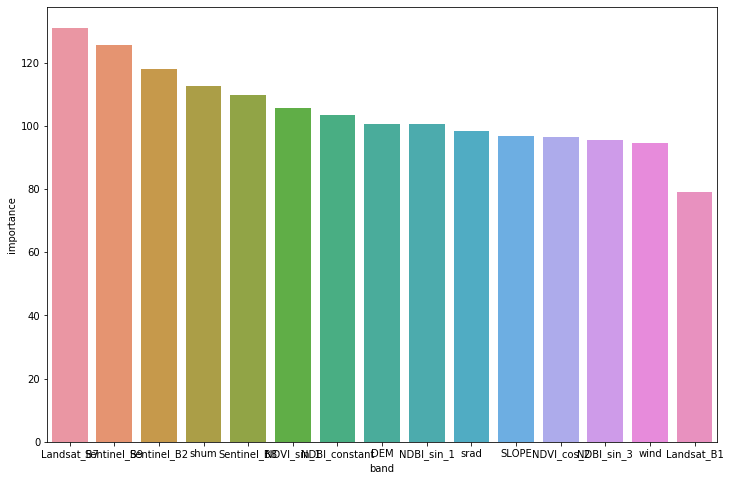

In [27]:
plt.figure(figsize=(12,8))
sns.barplot(x=gourp_mean.index,y ='importance',data=gourp_mean  )

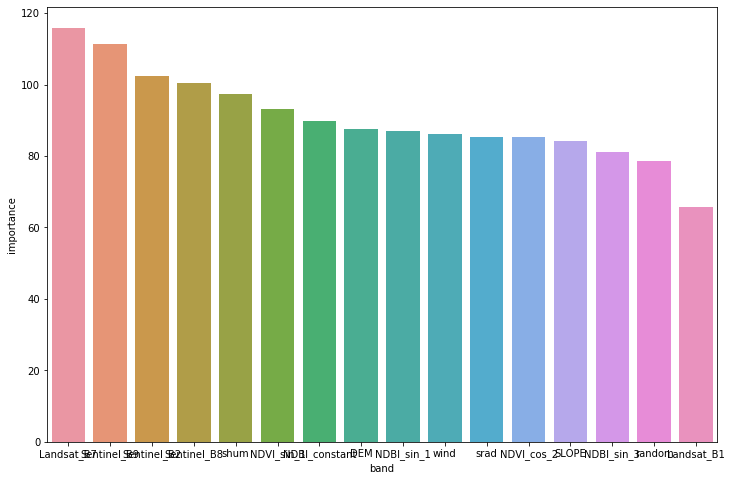

In [28]:
plt.figure(figsize=(12,8))
sns.barplot(x=gourp_mean_random.index ,y ='importance', data=gourp_mean_random )

#### Add one of the classified img to map

In [29]:
one = Classification_instances_df.iloc[0][3]
one

In [30]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(one,{'min':0,'max':1},'One')
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

#### calculate the accuracy of each radomness

In [31]:
acc = []

# calculate the accuracy of differnet randomness
for i in Classificatioin_result:
    
    accuracy = Accuracy_assesment(i[4]).Stp_1_Calculate_Accuracy()
    acc.append(accuracy)
    
    key = 'Recall_built'
    print(f'{i[1]}_{i[2]}-->Recall_built:{accuracy[key]}')

Sentinel_2014_2016_0-->Recall_built:93.71
Sentinel_2014_2016_1-->Recall_built:91.19
Sentinel_2014_2016_2-->Recall_built:92.65
Sentinel_2014_2016_3-->Recall_built:92.67
Sentinel_2014_2016_4-->Recall_built:94.18
Sentinel_2014_2016_5-->Recall_built:93.97
Sentinel_2014_2016_6-->Recall_built:94.48
Sentinel_2014_2016_7-->Recall_built:93.25
Sentinel_2014_2016_8-->Recall_built:95.4
Sentinel_2014_2016_9-->Recall_built:93.07
Sentinel_2017_2019_0-->Recall_built:93.17
Sentinel_2017_2019_1-->Recall_built:93.25
Sentinel_2017_2019_2-->Recall_built:95.32
Sentinel_2017_2019_3-->Recall_built:93.94
Sentinel_2017_2019_4-->Recall_built:94.34
Sentinel_2017_2019_5-->Recall_built:95.37
Sentinel_2017_2019_6-->Recall_built:94.0
Sentinel_2017_2019_7-->Recall_built:93.87
Sentinel_2017_2019_8-->Recall_built:94.24
Sentinel_2017_2019_9-->Recall_built:95.1


In [33]:
# # store the acc_df to local drive
# acc_df = pd.concat([Classification_instances_df[['year','seed']],pd.DataFrame(acc)],axis=1)
# acc_df.to_csv('./Result/Classification_Accuracy_landsat_sentinel.csv',index=False)

In [34]:
# access the acc_df
Sentinel_Acc = pd.read_csv('./Result/Classification_Accuracy_landsat_sentinel.csv')
Landsat_Acc  = pd.read_csv('./Result/Classification_Accuracy.csv')

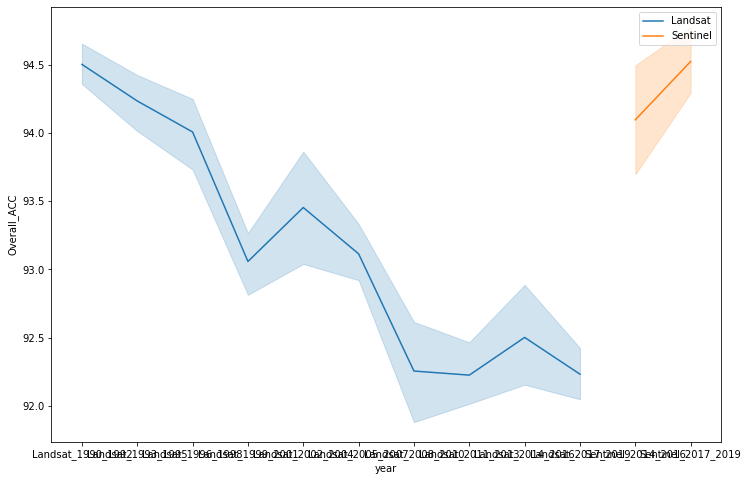

In [35]:
plt.figure(figsize=(12,8))

sns.lineplot(x='year',y='Overall_ACC',data=Landsat_Acc,label='Landsat')
sns.lineplot(x='year',y='Overall_ACC',data=Sentinel_Acc,label='Sentinel')

##### Export the classified_img

In [38]:
for item in Classificatioin_result:
     
    Classification_type = item[0]
    year = item[1]
    seed = item[2]
    img  = item[3]
    
    
    export_name = f'{Classification_type}_{year}_{seed}'
    
#     # export to Google Storage
#     task = ee.batch.Export.image.toCloudStorage(image          = img,
#                                                 description    = export_name,
#                                                 bucket         = 'north_china_plain',
#                                                 fileNamePrefix = export_name,
#                                                 region         = North_China_Plain.geometry().bounds(),
#                                                 scale          = 30,
#                                                 maxPixels      = int(1e13),
#                                                 skipEmptyTiles = True)
    
    #export to GEE asset
    asset_path = f'users/wangjinzhulala/North_China_Plain_Python/classification_img/Tree_50_{year}'
    
    task = ee.batch.Export.image.toAsset(   image          = img,
                                            description    = export_name,
                                            assetId        = f'{asset_path}/{export_name}',
                                            region         = North_China_Plain.geometry().bounds(),
                                            scale          = 30,
                                            maxPixels      = int(1e13)) 
    
    task.start()
    
    print(f'Exporting {export_name} successful!')

Exporting Lansat_Sentinel_Sentinel_2014_2016_0 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_1 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_2 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_3 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_4 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_5 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_6 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_7 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_8 successful!
Exporting Lansat_Sentinel_Sentinel_2014_2016_9 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_0 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_1 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_2 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_3 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_4 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_5 successful!
Exporting Lansat_Sentinel_Sentinel_2017_2019_6 successfu